In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import os
import glob
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf

2025-05-25 10:41:05.473661: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-25 10:41:05.514055: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-25 10:41:06.996125: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def load_otherdata():
    dossier = 'historical_data_2'
    dataframes = []
    noms_fichiers = []

    # Parcourir tous les fichiers dans le dossier
    for fichier in os.listdir(dossier):
        if fichier.endswith('.csv'):
            chemin_fichier = os.path.join(dossier, fichier)
            df_local = pd.read_csv(chemin_fichier)

            # Stocker le nom du fichier sans extension
            nom_fichier_sans_extension = os.path.splitext(fichier)[0]
            noms_fichiers.append(nom_fichier_sans_extension)

            # Renommer les colonnes (hors 'date') en ajoutant un suffixe basé sur les 3 premiers caractères du nom du fichier
            df_local = df_local.loc[:, ['date', 'close']]
            suffixe = nom_fichier_sans_extension[:3]
            df_local.columns = [col if col == 'date' else f'{col}_{suffixe}' for col in df_local.columns]

            # Ajouter le DataFrame à la liste
            dataframes.append(df_local)

    # Fusionner tous les DataFrames en un seul en utilisant la colonne 'date' comme clé
    df_global = dataframes[0]
    for df_local in dataframes[1:]:
        df_global = pd.merge(df_global, df_local, on='date', how='outer')
    df_global['date'] = pd.to_datetime(df_global['date'])
    return df_global

In [3]:
def merge_data(df_data, df_otherdataaa):
    df_local = pd.merge(df_data, df_otherdataaa, on='date')
    symbols = ['QQQ', 'GLD', 'USO']
    return df_local

In [4]:
other_data = load_otherdata()
print(other_data.head())

        date  close_GLD  close_QQQ  close_USO
0 2020-01-02     143.95     216.16     102.48
1 2020-01-03     145.86     214.18     105.44
2 2020-01-06     147.39     215.56     105.28
3 2020-01-07     147.97     215.53     105.04
4 2020-01-08     146.86     217.15     101.28


In [5]:
data_dir = 'historical_data'
csv_files = glob.glob(os.path.join(data_dir, '*.csv'))

In [134]:
csv_file = csv_files[0]
print(csv_file)

historical_data/AAPL_historical_data_2020-01-01_to_2024-12-31.csv


In [135]:
df = pd.read_csv(csv_file)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)
df.drop(columns=['changePercent', 'label', 'changeOverTime', 'adjClose'], inplace=True)
df = merge_data(df, other_data)

In [136]:
print(df.head())

        date   open   high    low  close     volume  unadjustedVolume  change  \
0 2020-01-02  74.06  75.15  73.80  75.09  135647456         135647456  1.0300   
1 2020-01-03  74.29  75.15  74.13  74.36  146535512         146535512  0.0700   
2 2020-01-06  73.45  74.99  73.19  74.95  118578576         118578576  1.5000   
3 2020-01-07  74.96  75.22  74.37  74.60  111510620         111510620 -0.3625   
4 2020-01-08  74.29  76.11  74.29  75.80  132363784         132363784  1.5100   

      vwap  close_GLD  close_QQQ  close_USO  
0  74.5250     143.95     216.16     102.48  
1  74.4825     145.86     214.18     105.44  
2  74.1450     147.39     215.56     105.28  
3  74.7875     147.97     215.53     105.04  
4  75.1225     146.86     217.15     101.28  


In [137]:
df_ML = df.drop(columns=['date'])
df_ML = df_ML.drop(columns=['unadjustedVolume'])

In [138]:
df_ML['variation'] = df_ML['high']-df_ML['low']

In [139]:
target_column = 'variation'

In [140]:
# Diviser les données en ensembles d'entraînement et de test
scaler = MinMaxScaler()
train_size = int(len(df_ML) * 0.8)
train_data = df_ML[:train_size]
test_data = df_ML[train_size:]
scaled_data_train = scaler.fit_transform(train_data)
scaled_data_test = scaler.transform(test_data)


# Préparer les données pour le générateur de séries temporelles
n_input = 10 
n_features = df_ML.shape[1]
target_index = df_ML.columns.get_loc(target_column)

# Créer des générateurs pour les ensembles d'entraînement et de test
train_generator = TimeseriesGenerator(scaled_data_train, scaled_data_train[:, target_index], length=n_input, shuffle=True, batch_size=32)
train_generator_notshuttle = TimeseriesGenerator(scaled_data_train, scaled_data_train[:, target_index], length=n_input)
test_generator = TimeseriesGenerator(scaled_data_test, scaled_data_test[:, target_index], length=n_input, batch_size=1)

In [110]:
#sauvegarde d'un modèle
model = Sequential()
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

In [141]:
# Construire le modèle
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True, activation='tanh'), input_shape=(n_input, n_features)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64, activation='tanh')))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

# Entraîner le modèle
model.fit(train_generator, epochs=50)

# Évaluer le modèle
loss = model.evaluate(test_generator)
print(f'Test Loss: {loss}')


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.3916
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0220
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0167
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0171
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0114
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0144
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0143
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0125
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0163
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0130
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0120
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0130
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0119
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0109
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0132
Epoch 16/50
32/

In [142]:
train_predictions = model.predict(train_generator_notshuttle)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step 


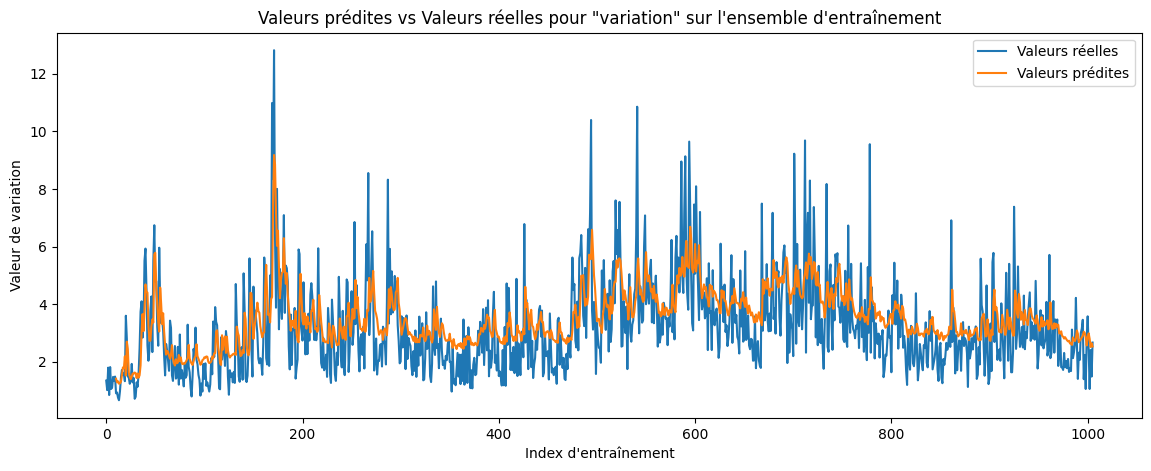

In [143]:
dummy_data_train = np.zeros((len(train_predictions), n_features))
dummy_data_train[:, target_index] = train_predictions.flatten()
train_predictions = scaler.inverse_transform(dummy_data_train)[:, target_index]

dummy_data_train_actual = np.zeros((len(scaled_data_train), n_features))
dummy_data_train_actual[:, target_index] = scaled_data_train[:, target_index]
train_actuals = scaler.inverse_transform(dummy_data_train_actual)[:, target_index]

# Tracer les résultats pour l'ensemble d'entraînement
plt.figure(figsize=(14, 5))
plt.plot(train_actuals, label='Valeurs réelles')
plt.plot(range(n_input, len(train_predictions) + n_input), train_predictions, label='Valeurs prédites')
plt.title(f'Valeurs prédites vs Valeurs réelles pour "{target_column}" sur l\'ensemble d\'entraînement')
plt.xlabel('Index d\'entraînement')
plt.ylabel(f'Valeur de {target_column}')
plt.legend()
plt.show()

In [144]:
from sklearn.metrics import r2_score

# Calculer le score R²
debut_test = len(train_actuals) - len(train_predictions)
r2 = r2_score(train_actuals[debut_test:], train_predictions)
print(f'R² Score (Keras model): {r2}')
##modèle qui prédit close suivant égale au close précédent
stupid_model = train_data[target_column].shift(1)

r2 = r2_score(train_actuals[1:], stupid_model[1:])
print(f'R² Score (lag): {r2}')

##modèle qui prédit la moyenne
target_mean = train_data[target_column].mean()
stupid_2 = target_mean * np.ones(len(train_data[target_column]))
r2 = r2_score(train_actuals[1:], stupid_2[1:])
print(f'R² Score (mean): {r2}')

stupid_3 = (stupid_model + stupid_2)/2
r2 = r2_score(train_actuals[1:], stupid_3[1:])
print(f'R² Score (mean): {r2}')

R² Score (Keras model): 0.31396570958068915
R² Score (lag): -0.07318239605497823
R² Score (mean): -1.3044812352536184e-06
R² Score (mean): 0.21371091791861563


In [145]:
test_predictions = model.predict(test_generator)

242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step 


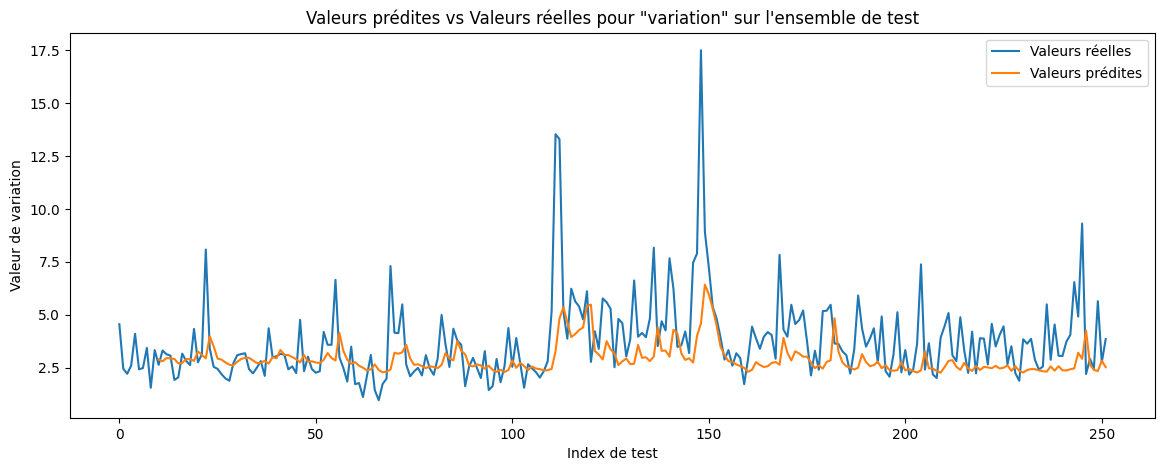

In [146]:
dummy_data_test = np.zeros((len(test_predictions), n_features))
dummy_data_test[:, target_index] = test_predictions.flatten()
test_predictions = scaler.inverse_transform(dummy_data_test)[:, target_index]

dummy_data_test_actual = np.zeros((len(scaled_data_test), n_features))
dummy_data_test_actual[:, target_index] = scaled_data_test[:, target_index]
test_actuals = scaler.inverse_transform(dummy_data_test_actual)[:, target_index]

# Tracer les résultats pour l'ensemble de test
plt.figure(figsize=(14, 5))
plt.plot(test_actuals, label='Valeurs réelles')
plt.plot(range(n_input, len(test_predictions) + n_input), test_predictions, label='Valeurs prédites')
plt.title(f'Valeurs prédites vs Valeurs réelles pour "{target_column}" sur l\'ensemble de test')
plt.xlabel('Index de test')
plt.ylabel(f'Valeur de {target_column}')
plt.legend()
plt.show()

In [147]:
debut_test = len(test_actuals) - len(test_predictions)
r2 = r2_score(test_actuals[debut_test:], test_predictions)
print(f'R² Score (Keras model): {r2}')
#modèle qui prédit le suivant égale au précédent
stupid_model = test_data[target_column].shift(1)
r2 = r2_score(test_actuals[1:], stupid_model[1:])
print(f'R² Score (lag): {r2}')

stupid_2 = target_mean * np.ones(len(test_data[target_column]))
r2 = r2_score(test_actuals[1:], stupid_2[1:])
print(f'R² Score (mean): {r2}')

stupid_3 = (stupid_model + stupid_2)/2
r2 = r2_score(test_actuals[1:], stupid_3[1:])
print(f'R² Score (mean): {r2}')

R² Score (Keras model): -0.025020108029539134
R² Score (lag): -0.07202121450475163
R² Score (mean): -0.07104019937336115
R² Score (mean): 0.19661477761348867


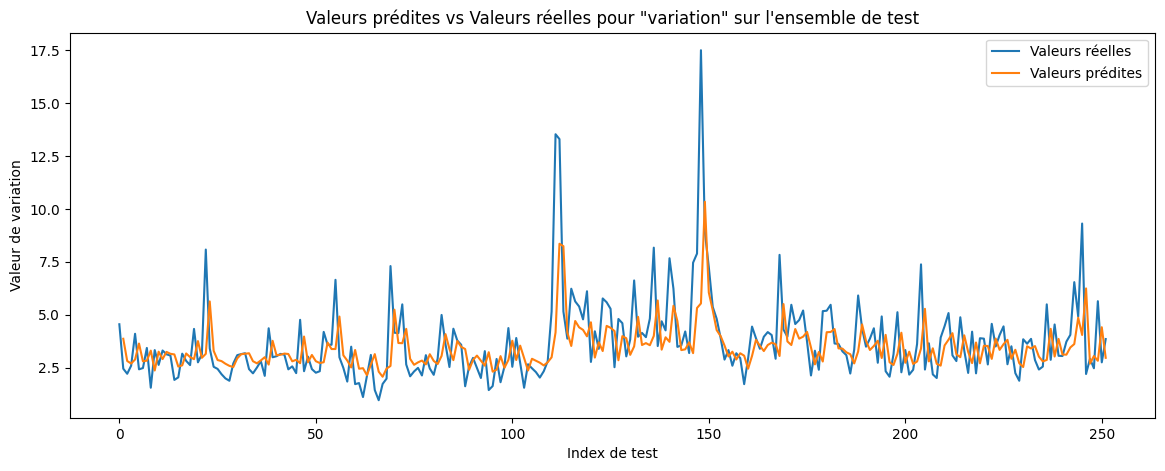

In [148]:
plt.figure(figsize=(14, 5))
plt.plot(test_actuals, label='Valeurs réelles')
plt.plot(stupid_3.reset_index(drop=True), label='Valeurs prédites')
plt.title(f'Valeurs prédites vs Valeurs réelles pour "{target_column}" sur l\'ensemble de test')
plt.xlabel('Index de test')
plt.ylabel(f'Valeur de {target_column}')
plt.legend()
plt.show()